In [1]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import lsim
import matplotlib.pyplot as plt
from BoreholeFlow import BhFlow
from BoreholeFlow import PlotFigures

In [2]:
# Created by Joshua Thompson 
# Last updated 09/02/2022
nskip = 1

R0 = 1000.0000
Rw = 20.32 / 2
dhtotal = 2.5

# Hydraulic conductivity (cm/s)
K = [1e-5, 3e-5, 6e-5, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 6e-5, 1e-5, 6e-5, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 6e-5, 3e-5, 6e-5, 1e-4, 1e-4, 1e-4, 1e-4]
K = np.array([i * 100 for i in K]).reshape(25, 1) # apply list comprehension for multiplying 100 by each element in list.

# True concentration in the aquifer (mg/cm^3)
C0 = np.array([500, 400, 300, 250, 40, 25, 30, 50, 150, 400, 500, 300, 50, 40, 30, 25, 50, 150, 300, 500, 300, 150, 40, 30, 20])

# -----------------------------------------------------
# Instantiate the class
# -----------------------------------------------------
p = BhFlow(K, R0, Rw)

# Define number of layers based on the number of Ks
nlayers = p.NumberOfLayers()

# Create thickness of each wellbore interval
b = 200 * p.NlayersOnesArray(nlayers)

zwellbot = -5000

# Define layer head drops.
Keff = np.sum(b) / np.sum(b / K) # effective hydraulic conductivity

dh = Keff/K * b/np.sum(b) * dhtotal # head drops

h0 = p.NlayersZerosArray(nlayers) # Far field heads (in Aquifer)
h0[0] = dh[0] / 2 + 10000
for i in np.arange(1,nlayers):
    h0[i] = h0[i-1] + dh[i-1]/2 + dh[i]/2

ztop, zmid, zbot = p.Discretize(zwellbot, nlayers, b) # Discretize the well

# -----------------------------------------------------
# -----------------------------------------------------
# Ambient flow
# -----------------------------------------------------
# -----------------------------------------------------
# Flow under ambient conditions
zpump = -100 * np.ones((1,1))
Qpump = np.zeros((1,1))
zobs = -100 * np.ones((1,1))
Qsampling = np.zeros((1,1))

# Create empty list to store data
ctrueAll, cobsAll, gAll, zobsAll, zpumpAll, QpumpAll, QobsAll, QbAll, QrAll, hAll = p.MakeDataLists()

for i in range(len(zobs)):
    # Run flow model
    Qb, Qr, h, zmid, zbot, ztop= p.BoreholeFlowModel(nlayers, b, h0, zwellbot, ztop, zmid, zbot, zobs[i], zpump, Qpump, Qsampling)
    # Run transport model
    c, cobs, G = p.BoreholeTransportModel(nlayers, b, Qb, Qr, C0, ztop, zmid, zbot, zobs[i], zpump, Qpump, Qsampling)
    # Append data to empty lists
    cssAmbient, cobsAmbient, gAmbient, zobsAmbient, zpumpAmbient, QpumpAmbient, QobsAmbient, QbAmbient, QrAmbient, hAmbient = p.AppendData(c, cobs, G, zobs[i], zpump, Qpump, Qsampling, Qb, Qr, h, ctrueAll, cobsAll, gAll, zobsAll, zpumpAll, QpumpAll, QobsAll, QbAll, QrAll, hAll)

# -----------------------------------------------------
# -----------------------------------------------------
# Pump at 100cm depth at 8 L/min, approach to Steady State
# -----------------------------------------------------
# ----------------------------------------------------- 
Qpump = 8000 / 60
zpump = -100 * np.ones((1,1))
Qsampling = np.zeros((1,1))
zobs = np.arange(b[0] / 2, np.sum(b) - b[-1]/2 + 1, nskip * b[0]) + zwellbot
nobs = len(zobs)

tend = 24 * 60 * 60 * 10
t = np.linspace(0, tend, 1000)

ctrueAll, cobsAll, zobsAll, cssAll, tAll, QbAll, QrAll = p.MakeDataListsTransient()

for i in range(len(zobs)):
    Qb, Qr, h, zmid, zbot, ztop= p.BoreholeFlowModel(nlayers, b, h0, zwellbot, ztop, zmid, zbot, zobs[i], zpump, Qpump, Qsampling)
    
    c, css, cobs, tout = p.TransientTransportModel(t, nlayers, b, Qb, Qr, C0, cssAmbient[0], ztop, zmid, zbot, zobs[i], zpump, Qpump, Qsampling)

    ctrueLF1, cobsLF1, zobsLF1, cssLF1, tLF1, QbLF1, QrLF1 = p.AppendDataTransient(c, cobs, zobs[i], css, t, Qb, Qr, ctrueAll, cobsAll, zobsAll, cssAll, tAll, QbAll, QrAll)
# Convert list to array
ctrueLF1, cobsLF1, zobsLF1, cssLF1, tLF1, QbLF1, QrLF1 = p.Convert2ArraysTransient(nlayers, zobs, t, ctrueAll, cobsAll, zobsAll, cssAll, tAll, QbAll, QrAll)

cobsLF1T = cobsLF1.T

imin = []
for i in range(nobs):
    iset = np.argwhere(np.abs((cobsLF1T[:, i] - cssLF1[i]) / cssLF1[i]) < 0.05)[0]
    if iset.size> 0:
        imin.append(iset[0] + 1)
    else:
        imin.append(np.nan)
imin = np.asarray(imin)
tLF1T = tLF1.T

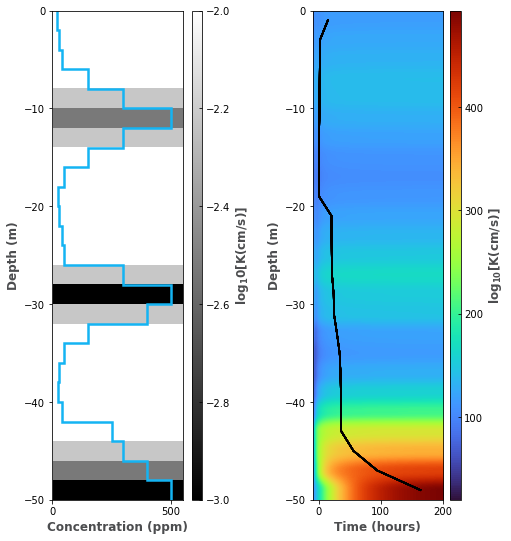

In [3]:
plot = PlotFigures()
plot.PlotFigure4(C0, K, zobs, cobsLF1, tLF1T, imin)

In [4]:
# -----------------------------------------------------
# EXPORTING FOR DATA VALIDATION
# -----------------------------------------------------
# path = r'C:\Users\thom675\OneDrive - PNNL\summer_internship_2022\borehole flow\Python\python_output'
# file_name = '\Python_Output_Fig4_CobsLF1.txt'

# np.savetxt(path + file_name, cobsLF1)